## Table of contents
1. [Introduction](#paragraph0)
    1. [Problem Statement](#subparagraph0)
    2. [Data collection and preparation](#subparagraph0)
    3. [Initial flow](#subparagraph0)
2. [Our approach](#paragraph1)
    1. [Workflow pipeline ](#subparagraph1)
    2. [Data Pre-processing](#subparagraph2)
        1. [Outlier Detection](#subsubparagraph21)
        2. [Data Cleaning](#subsubparagraph22)
    3. [Real Data](#subparagraph3)
    4. [CNN model - Overfitting](#subparagraph4)
    5. [Data Augmentation](#subparagraph5)
       1. [Traditional augmentation methods](#subsubparagraph51)
           1. [Jittering](#subsubsubparagraph511)
           2. [Magnitude Warping](#subsubsubparagraph512)
           3. [Time Warping](#subsubsubparagraph513)
           4. [Window Warping](#subsubsubparagraph514)
           5. [Scaling](#subsubsubparagraph515)    
       2. [Combined Traditional augmentation methods](#subsubparagraph52)
           1. [Jittering + Magnitude Warping](#subsubsubparagraph521)
           2. [Jittering + Time Warping](#subsubsubparagraph522)
           3. [Jittering + Window Warping](#subsubsubparagraph523)
           4. [Scaling + Magnitude Warping](#subsubsubparagraph524)
           5. [Scaling + Time Warping](#subsubsubparagraph525)
           6. [Magnitude warping + Window Warping](#subsubparagraph526)
       3. [VAE augmentation](#subsubparagraph53)
           1. [Convex Hull](#subsubsubparagraph21)
    6. [Training CNN using augmented and lab data](#subparagraph6)
    7. [Cross Validation with different configurations](#subparagraph7)
       1. [Data preparation for cross validation](#subsubparagraph71)
       2. [Cross validation Metrics](#subsubparagraph72)
           1. [Confusion Matrix](#subsubsubparagraph721)
           2. [ROC and Precision Recall Curves](#subsubsubparagraph722)
           3. [Test metrics](#subsubsubparagraph723)
3. [Conclusion and future work](#paragraph2)
4. [References](#references)
5. [Appendix](#appendix)

In [2]:
pip install nbconvert[webpdf]

Note: you may need to restart the kernel to use updated packages.


'C:\Users\HP\New' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from lib import data_preparation
from lib import metrics
from lib import Augmentation_methods
from lib import vae_augmentation
from lib.data_preparation import fake_lab_data

import pathlib
import pandas as pd
import numpy as np
from numpy import sqrt
from numpy import argmax
import seaborn as sns
from scipy.signal import stft
import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import MaxPooling2D ,Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape

from scipy.spatial import ConvexHull
from matplotlib.path import Path
from matplotlib.patches import Rectangle

2023-02-12 10:55:34.970826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Introduction <a name="paragraph0"></a>
### Problem Statement <a name="subparagraph0"></a>
Patients in nursing homes are at a high risk of slipping out of bed. Such falls are prevalent in nursing homes and can occur for a variety of reasons. Such falls can be life-threatening and must be addressed as soon as possible by caretakers or nurses to prevent significant damage and immediate medicine.

The project goal is to develop a cost-effective system for detecting such falls and alerting nursing staff. At the same time, the system needs to be efficient as it should not incorporate any smartwatches, wearable devices, and surveillance systems. The developed systems are made up of gyro sensors that are embedded into the beds. These sensors generate vibrations based on the movements on and around the bed. As a result, these data would consist of many vibration patterns, and we would need to distinguish the actual patient fall from other falls and vibrations. To address this, we have implemented an AI model that would correctly classify a patient fall from other falls.

### Data collection and preparation <a name="subparagraph0"></a>
To get the data for the research project, the developed system was connected to a microcontroller. This develoepd systems were installed in several rooms in nursing home.To detect vibrations in the event of any movement or fall, sensors were mounted to the patient's room and bed. The vibration data is in the form of acceleration values in all the three different axes(x,y,z). Additionally, we have data from the nursing home from times the sensor was inactive and recorded no fall events. Further in the data preparation phase, data is converted in the form of 10 seconds snippet to identify the falls. 

The collected data was insufficient to move further with the project, therefore data was manually created in the lab to simulate the behavior of actual falls and other falls. A dummy body weighing around 70 and 75 kg was used in the lab to imitate real fall behavior (average weight of a person). To collect the dummy falls data, this dummy was pushed from the bed using a crane-lift equipment. Along with this, a number of other items, including trays, water bottles, and books, were dropped to give the classification algorithm different kinds of input fall events to identify the difference between a real fall event and a false one. The data is then prepared for the lab experiments along with the data received from sensors in various rooms in the nursing home.

### Initial flow <a name="subparagraph0"></a>
For the initial phase ,two models the logistic regressor and CNN were already built to classify the real and fake fall events for lab experiments. 

<b>Logistic regressor</b>
It attempts to classify whether or not a fall has actually occurred. This fall could be an object fall or a dummy fall. The logistic reregressor is fed both the negative and positive samples to accomplish this. Positive events are various falls events(including dummy fall) measured in the laboratory, while the negative samples are taken from two 24-hour measurements taken when the laboratory was empty. These measurements are presented as 10-second samples. The maximum value, the median, the mean, the lower and upper quartile values are calculated and used as features in the logistic regressor model for binary classification.

<b>Convolution Neural Network</b>
It is used to further distinguish the real fall events from the other object fall events. For CNN, the data snippets are fed in the form of frequency spectrum which are obtained using short-time fourier transform. This frequency spectrum or STFT images are fed as inputs for training the CNN model.The CNN model consists of four layers:
- A <b>Conv2D</b> layer with 8 filters of size 63x5 with a ReLU activation function and input shape(63, 251, 1).
- A <b>MaxPooling2D</b> layer with a window size of (1, 4).
- A <b>Flatten</b> layer that removes the 2-dimensionality of the data.
- A <b>Dense</b> layer with 1 output parameter.  <br>
The model is compiled using the Adam optimizer and binary cross-entropy loss function, and is evaluated using accuracy as a metric. Finally, a threshold value is adjusted and used as a parameter to evaluate the trained model on the whole data.

# Our approach <a name="paragraph1"></a>

## Workflow pipeline <a name="subparagraph1"></a>

We built a pipeline to have a clear picture of how to proceed with each and every step of building, evaluating and enhancing the model for more efficient classification. Our case study was completed through several stages with the initial flow being the starting point.

![pipeline.png](figures/pipeline.png)

<b>Data preparation</b> for the lab experiments as well as real nursing home data is done in the methods/functions defined in <b>data_preparation.py</b> module. The existing models were trained and evaluated on the lab experiments data which are obtained from the function <b>'fake_lab_data()'</b> defined in this module. Several functions(which are used throughout the notebook) are compiled in each of these modules which can then be easily imported here for concise code and easier maintainence. All the modules are put together in the <b>lib<b> folder.

The acceleration values(x,y,z) values at different settings and experiments for each of the sensors are obtained from the 'lab_df'

In [3]:
# Loading positive, negative and dummy data
dummy_data, all_events, all_labels,pos_data,pos_labels,lab_df = fake_lab_data()

In [4]:
lab_df.head(3)

,teensy,experiment,run,rep,t,x,y,z
0,2,1.5L Flasche,L1,1,0.000000,14.0,1.0,1040.0
1,2,1.5L Flasche,L1,1,0.000623,12.0,4.0,1041.0
2,2,1.5L Flasche,L1,1,0.001247,10.0,-1.0,1038.0


To begin with the further work, we implemented <b>cross validation</b> with different models(along with logistic regression) since they offer a way to validate the model's performance and robustness and ensure that the model is generalizing well to unseen data. 

In [5]:
# Cross-validation with different models
x_train, x_test, y_train, y_test = train_test_split(all_events, all_labels.ravel(), test_size=0.2)
lr, lr_score = metrics.get_score(LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=1000), x_train, x_test, y_train, y_test)
rf, rf_score = metrics.get_score(RandomForestClassifier(n_estimators=40), x_train, x_test, y_train, y_test)
svc,svc_score = metrics.get_score(SVC(gamma='auto'), x_train, x_test, y_train, y_test)

print("Logistic Regression Score: ", lr_score)
print("Random Forest Score: ", rf_score)
print("SVC Score: ", svc_score)

Logistic Regression Score:  1.0
Random Forest Score:  1.0
SVC Score:  1.0


In [6]:
lr_ct = pd.crosstab(lr.predict(x_test), y_test)
rf_ct = pd.crosstab(rf.predict(x_test), y_test)
svc_ct = pd.crosstab(svc.predict(x_test), y_test)

cts = [lr_ct, rf_ct, svc_ct]
titles = ['Logistic Regression', 'Random Forest', 'SVC']
concatenated_cts = pd.concat(cts, axis=0, keys=titles)
print(concatenated_cts)

col_0                         0    1
                    row_0           
Logistic Regression 0      3990    0
                    1         0  226
Random Forest       0      3990    0
                    1         0  226
SVC                 0      3990    0
                    1         0  226


- Logistic regression performed classification well without any misclassification of fall events and so did the other models. Since the data is not enough and it has not been tested in the real scenario therefore there is no drastic results among the various models.

## Data Pre-processing <a name="subparagraph2"></a>

In the following stage, we attempted to investigate the data collected by the nursing home's sensors in order to draw any useful insights or to reduce the sample space by identifying irrelevant data.

From the lab_df, the acceleration due to gravity along the z-axis is plotted against the time for one of the three sensors. From the graph(below), the values around 1000 near the surface of the Earth suggests that the accelerometer is measuring the combined effect of gravity and the acceleration caused by motion or falling of the dummy body used in experiment. The spikes for certain seconds are due to sudden or rapid movements that cause a significant change in velocity and result in a higher acceleration measurement.

In [7]:
# all sensors data with different experiments and settings 
lab_df.rename(columns={'teensy': 'sensors', 'run': 'setting'}, inplace=True)
lab_df.head(2)

,sensors,experiment,setting,rep,t,x,y,z
0,2,1.5L Flasche,L1,1,0.000000,14.0,1.0,1040.0
1,2,1.5L Flasche,L1,1,0.000623,12.0,4.0,1041.0


[Text(0.5, 0, 'time(t)'), Text(0, 0.5, 'accelration(z-axis)')]

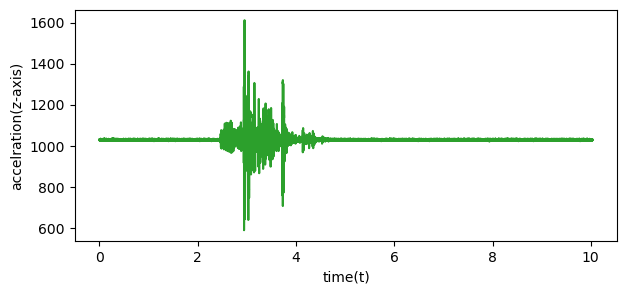

In [8]:
# To filter dummy data at L1 for sensor 3
df_conf = lab_df[(lab_df.experiment == 'Dummy') & (lab_df.setting == 'L1') & (lab_df.sensors == '3')]

fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(df_conf['t'], df_conf['z'], 'tab:green')
ax.set(xlabel='time(t)', ylabel='accelration(z-axis)')  

- It is important to note that the accelerometer values are subject to noise and errors, and the spikes in the graph could also be the result of these inaccuracies. 

### Outlier Detection <a name="subsubparagraph21"></a>

Detecting any outliers to reduce the input data is a critical step because noisy data can make it difficult to observe patterns and draw insights. To accomplish this, acceleration against time plots for dummy data from each sensor in eight different settings were plotted. 

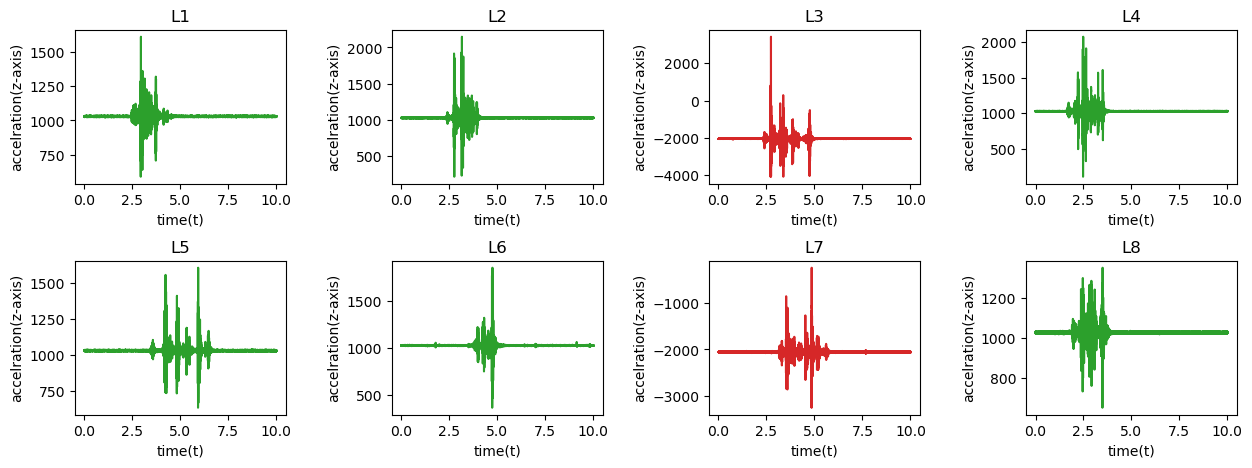

In [9]:
# To plot the z vs t graph for L1-L8 settings for sensor 3
runs = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']
df_list = []
for run in runs:
    df_conf = lab_df[(lab_df.experiment == 'Dummy') & (lab_df.setting == run) & (lab_df.sensors == '3')]
    df_list.append(df_conf)

fig, axs = plt.subplots(2, 4, figsize=(15, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
titles = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8']
for i, ax in enumerate(axs.flat):
    color = 'tab:green'
    if titles[i] in ['L3', 'L7']:
        color = 'tab:red'
    ax.plot(df_list[i]['t'], df_list[i]['z'], color)
    ax.set_title(titles[i])
    ax.set(xlabel='time(t)', ylabel='accelration(z-axis)')


One obvious observation for one of the sensors at settings <b>L3</b> and <b>L7</b> was that the acceleration values near the earth's surface were in the <b>negative 2000s</b>, which is quite absurd. By removing these outliers, the cleaned dummy data is more likely to reflect the actual acceleration values and provide more reliable information for model building and fall classification.

### Data Cleaning <a name="subsubparagraph22"></a>

Data cleaning is an important step in the data preprocessing phase as it helps to identify and remove errors, inconsistencies, and outliers that can negatively impact the accuracy of the results obtained from the data. Therefore, the cleaned dummy data is obtained by getting rid of the sensor data lesser than zero, i.e, negative values.

In [10]:
# adding labels after creating the dummy dataframe
labels = [f"dummy" for i in range(len(dummy_data))]
df_dummy_data = pd.DataFrame(dummy_data, columns=['z'], index=labels).reset_index()
df_dummy_data = df_dummy_data.rename(columns={"index": "label"})

In [11]:
# Create a mask to filter the data based on the condition x[0] > 0
mask = df_dummy_data['z'].apply(lambda x: x[0] > 0)

# Use the mask to select only the rows in the dataframe that meet the condition
cleaned_dummy = df_dummy_data[mask]
faulty_dummy = df_dummy_data[~mask]

# Reset the index of the cleaned and faulty dummy data dataframes
cleaned_dummy.reset_index(drop=True, inplace=True)
faulty_dummy.reset_index(drop=True, inplace=True)
cleaned_dummy.head(4)

,label,z
0,dummy,"[1028.0, 1030.0, 1028.0, 1030.0, 1030.0, 1028...."
1,dummy,"[1038.0, 1040.0, 1040.0, 1040.0, 1042.0, 1038...."
2,dummy,"[1038.0, 1040.0, 1042.0, 1036.0, 1036.0, 1036...."
3,dummy,"[1039.0, 1039.0, 1037.0, 1039.0, 1040.0, 1039...."


## Real Data <a name="subsubparagraph3"></a>

The real data recorded from the sensors at different time stamps are loaded with respect to different room numbers in the nursing home and the specified hour. 

In [12]:
#loading real data
from lib import data_preparation
df_real_data = data_preparation.load_real_data(room="206 B",year=2022, month=11, day=13, startHour=12,lastHour=14)
df_real_data.head(4)

5738070 rows from filepath: 2022-11-13_12-00-00
5696160 rows from filepath: 2022-11-13_13-00-00
5740890 rows from filepath: 2022-11-13_14-00-00


,z,time
0,1014,2022-11-13 12:00:00.000000
1,1018,2022-11-13 12:00:00.000625
2,1020,2022-11-13 12:00:00.001250
3,1018,2022-11-13 12:00:00.001875


<b>Window shifting</b> has been used for segmentation of the hourly data. This method allows the division of a large span of data into smaller, overlapping segments, enabling the analysis of local features and patterns within the data while observing the short time fourier transform of the real data. Therefore in order to observe any real fall event, we segmented one hour data with the segmentation window of 10 mins. The segmentation window can also be adjusted by setting the interval_time to desired minutes. The step_size can also be adjusted which defines the overlap time of data for the next shifting window.

In [13]:
#loading segmented data 
df_segmented = data_preparation.shifting_window_segmentation(df_real_data,stepsize= 5)
df_segmented.head(2)

,left_t,right_t,z,features
0,2022-11-13 12:00:00,2022-11-13 12:00:10,"[1014, 1018, 1020, 1018, 1020, 1020, 1014, 101...","[[3719263.39772316, 2.3690981601563283, 1039.8..."
1,2022-11-13 12:00:05,2022-11-13 12:00:15,"[1020, 1020, 1018, 1018, 1016, 1016, 1018, 101...","[[41.623465140625456, 2.3974651406248904, 2.94..."


In [14]:
# prediction using real data on the logistic regressor trained on the dummy data
Real_Events = []
for i in range(len(df_segmented)):
    Real_Events.append(df_segmented["features"].iloc[i].flatten())

prediction = lr.predict(Real_Events)

df_segmented["predicted"] = prediction
df_segmented.head(3)

,left_t,right_t,z,features,predicted
0,2022-11-13 12:00:00,2022-11-13 12:00:10,"[1014, 1018, 1020, 1018, 1020, 1020, 1014, 101...","[[3719263.39772316, 2.3690981601563283, 1039.8...",1
1,2022-11-13 12:00:05,2022-11-13 12:00:15,"[1020, 1020, 1018, 1018, 1016, 1016, 1018, 101...","[[41.623465140625456, 2.3974651406248904, 2.94...",0
2,2022-11-13 12:00:10,2022-11-13 12:00:20,"[1018, 1016, 1017, 1016, 1020, 1022, 1020, 102...","[[41.32320159765557, 2.470201597656416, 2.9493...",0


The approximate time of the real fall at the nursing home was provided. We observed the real data around that hour and plotted the short time fourier transform of the time snippets for which logistic regressor predicted as a <b>real fall (1)</b>. Among the various stft plots, a distinct plot whose behaviour looked similar to a dummy fall has been shown below. The <b>short thime fourier transform(STFT)</b> plot provides valuable information about the frequency components of the signal over time, which can be used to distinguish a fake fall from a real fall and identify any common patterns or trends. 

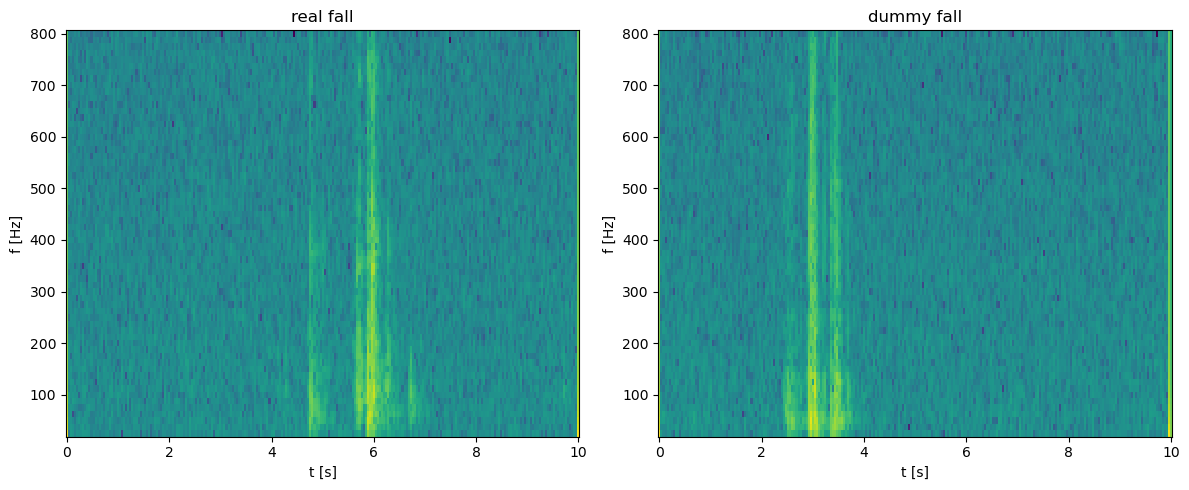

In [15]:
# stft plot of dummy and real fall
Augmentation_methods.plot(label1 = "real fall", data1 = df_segmented['z'].iloc[588], 
     label2 = "dummy fall", data2 = dummy_data[5])

- Although we have the data for one of the real fall events, this real fall event is not enough for model evaluation. Therefore, all the further experiments and testing has been carried out for the data from the lab experiments. Dummy data has been considered as the real fall events data and any other falls as a false one.

### CNN model - Overfitting <a name="subparagraph4"></a>

In the initial work on the CNN  model, the normalized value of spectrums obtained from the <b>'SignalToSpectrum'</b> function is calculated and passed as input to the CNN model. 

In [16]:
L = []
for (teensy, event, run, rep), ss in lab_df.groupby(["sensors", "experiment", "setting", "rep"]):
    L.append({"event": event,
              "run": run,
              "istSturz": int(event == "Dummy"),
              "signalLenght": len(ss["z"]),
              "spectrum": data_preparation.SignalToSpectrum(ss["z"])})
pos_event_df = pd.DataFrame.from_dict(L)
 # normalize the spectrum to facilitate training
pos_event_df["normalizedSpectrum"] = pos_event_df["spectrum"] / pos_event_df["spectrum"].map(np.max).max()

# Dividing the positive event df in 60% for train and 40% for test for further cross-validation
pos_event_train_df = pos_event_df.sample(frac = 0.60) 
pos_event_test_df = pos_event_df.drop(pos_event_train_df.index) 

pos_event_df.head(2)

,event,run,istSturz,signalLenght,spectrum,normalizedSpectrum
0,1.5L Flasche,L1,0,15976,"[[[220.68784142956994], [0.11347713586453584],...","[[[0.32260105096654695], [0.000165880653204249..."
1,1.5L Flasche,L1,0,16038,"[[[220.7760221941459], [0.4810628935081976], [...","[[[0.3227299534341363], [0.0007032167881178003..."


In [17]:
# Defining the CNN model
mdl = Sequential()
mdl.add(Conv2D(8, (63, 5), activation="relu", input_shape=(63, 251, 1)))
mdl.add(MaxPooling2D((1, 4)))
mdl.add(Flatten())
mdl.add(Dense(1))
mdl.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
mdl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 247, 8)         2528      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 61, 8)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 488)               0         
                                                                 
 dense (Dense)               (None, 1)                 489       
                                                                 
Total params: 3,017
Trainable params: 3,017
Non-trainable params: 0
_________________________________________________________________


2023-02-12 10:57:04.519180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Define the features and target
X = np.stack(pos_event_df["normalizedSpectrum"].to_list())
y = pos_event_df["istSturz"].to_numpy()
train, test = train_test_split(range(len(y)), test_size=0.2)

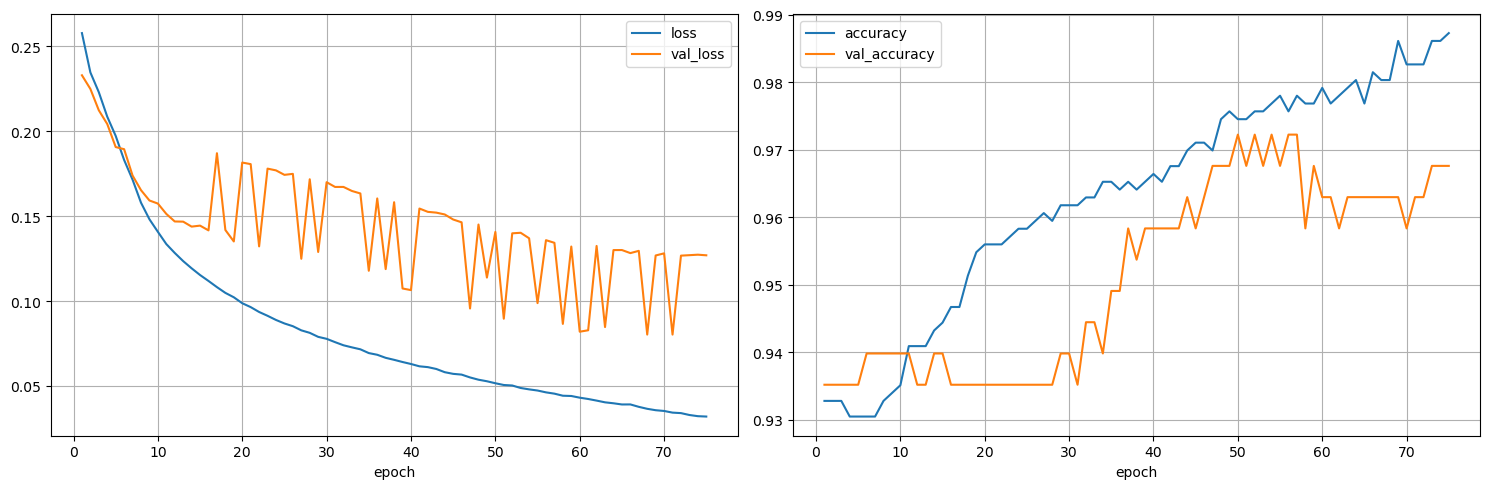

27/27 [==============================] - 1s 19ms/step - loss: 0.0320 - accuracy: 0.9873 - val_loss: 0.1270 - val_accuracy: 0.9676


In [19]:
# Training and plotting the loss and accuracy for training and the validation dataset for every epoch
callbacks_list = [metrics.PlotLearning()]
history = mdl.fit(X[train, ], y[train], epochs=75, validation_data=(X[test,], y[test]),callbacks=callbacks_list)

- It is apparent that the model has a <b>high degree of overfitting</b>, as evidenced by a very high value of accuracy from the initial epoch. This issue is attributed to a lack of sufficient data and was addressed by incorporating augmentation techniques to mitigate excessive overfitting in the CNN model.

## Data Augmentation <a name="subparagraph5"></a>

When training deep learning models, overfitting often occurs when the model becomes too complex for the limited amount of training data. This results in the model memorizing the training data, making it unable to generalize well to unseen data. <b>Data augmentation</b> is a technique that addresses this by artificially increasing the size of the training dataset by applying transformations to the existing samples. The augmented data is then used to train the model.

In addition, data augmentation can also help to increase the robustness of the model to variations in the data, as it generates new samples that are representative of the real-world variations in the data. This can result in a model that is less prone to overfitting, covers unexplored input space and more robust to real-world variations in the data.

### Traditional augmentation methods <a name="subsubparagraph51"></a>

All the traditional data augmentation methods used for our scenario can help increase the diversity of the training data and reduce overfitting, making the CNN model more robust and effective in detecting falls. By combining these techniques, it is possible to create a large and varied dataset that can better represent the different types of movements and vibrations that the sensors may detect in a real-world scenario.

#### 1. Jittering <a name="subsubsubparagraph511"></a>
Jittering is a data augmentation technique that involves adding random noise to the input data to increase its diversity. The purpose of jittering is to create new and unique training examples from the original data, which helps the model generalize to new data better and reduces overfitting. In the case of detecting falls in nursing home patients, jittering can help the model recognize different variations of vibrations caused by falls, such as those produced by different weights, movements or falls with different intensities. By adding random noise to the vibration data, the model will be exposed to a wider range of variations, improving its ability to distinguish falls from other types of vibrations. The <b>'add_white_noise'</b> function in <b>Augmentation_methods.py</b> accepts 'data' and 'sigma' as an input to the function.
Data in our case is the dummy data and sigma refer to the standard deviation of the noise. Augmented data is returned as an output from the function and is passed to <b>'plot_augmented'</b> to visualize the added noise.

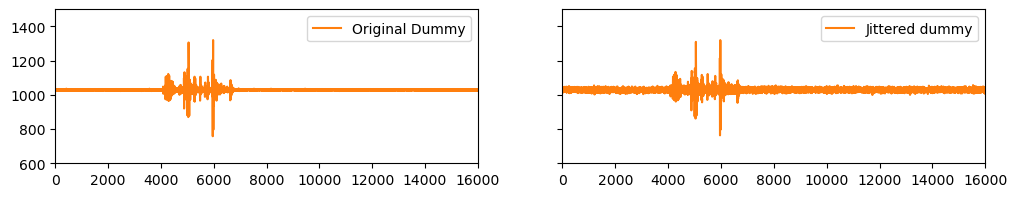

In [22]:
Noise_dummy = Augmentation_methods.add_white_noise(dummy_data[0], 0.50)
Augmentation_methods.plot_augmented(dummy_data[0],Noise_dummy,orig_label = "Original Dummy", aug_label= "Jittered dummy" )

#### 2. Magnitude Warping <a name="subsubsubparagraph512"></a>
Magnitude-warping (MagW) changes the magnitude of each sample by convolving the data window with a smooth curve varying around one. In this scenario, this method can help to simulate different levels of intensity in the vibration data, allowing the model to better recognize falls with different levels of severity. The function <b>'magnitudewarping'</b> accepts data, sigma, knot as inputs. data refers to the data to be augmented which in our case is dummy fall data. sigma defines the standard deviation of the knots of the randomly generated cuve whereas knots define the complexity of the curve. sigma and knot are used by the function <b>'GenerateRandomCurves'</b> called inside the 'magnitudewarping' function to generate random curves using cubic spline method. Based on this curve, smooth-varying noise is applied to the entire data. The <b>'plotcurve_mw'</b> function uses the dummy data, augmented data and curve data(returned from 'magnitudewarping' function) as inputs and different graphs are obtained to see the variataion in the augmented and original dummy data.

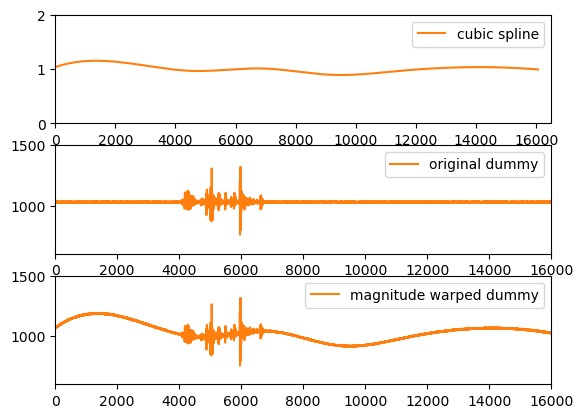

In [23]:
curve, magnitude_warped_dummy  =  Augmentation_methods.magnitudewarping(dummy_data[0],0.1, 6)
Augmentation_methods.plotcurve_mw(curve = curve, orig_dummy = dummy_data[0], aug_dummy = magnitude_warped_dummy, orig_label = 'original dummy', aug_label = 'magnitude warped dummy')

- With increase in the value of knot, we can increase the effect and variation of magnitude warped dummy when compared with the original dummy

#### 3. Time Warping <a name="subsubsubparagraph513"></a>
Time warping refers to modifying the timing of the accelerometer data. This can be done, for example, by stretching or compressing the data along the time axis. This can help to increase the variability of the training data and make the model more robust to variations in the timing of the data, which can be important for fall detection. <b>'DA_TimeWarp'</b> function accepts 'data', 'sigma', and 'knots' has an input to the function. Similar to the magnitude warping, based on 'sigma' and 'knot' values random curve is generated and based on this curve, time axis is stretched or compressed. <b>'plotcurve_tw'</b> uses the augmented data returned from the 'DA_TimeWarp' to visualize the augmented time warped data.

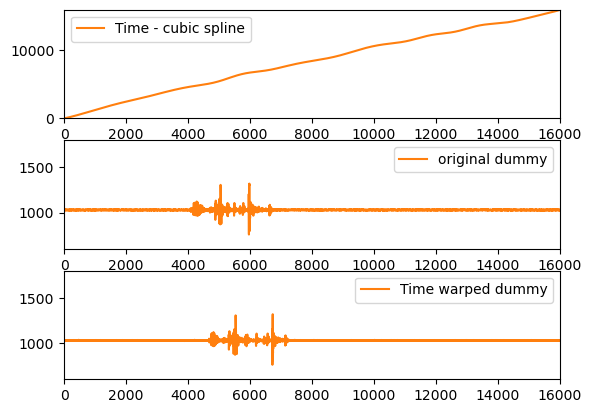

In [24]:
time_curve,Time_warped_dummy, Time_warped_dummy_stft = Augmentation_methods.DA_TimeWarp(dummy_data[0], 0.3, 20)
Augmentation_methods.plotcurve_tw(curve = time_curve, orig_dummy = dummy_data[0], aug_dummy = Time_warped_dummy,orig_label = 'original dummy', aug_label = 'Time warped dummy')

- It is important to note that extreme manipulation of the time axis is not suitable for our use case as it will modify the time axis too much which can lead to augmented data altlough being similar to dummy data but would not make sense in reality(since taking such input samples where the time of the fall has been slowed down can lead to incorrect training and classification). Even if it is used for augmentation, sigma and knot values should be kept as minimum as possible.

#### 4. Window Warping <a name="subsubsubparagraph514"></a>
Alternatively, a popular method of time warping called window warping that defines a slice in the time series data and speeds up or down the data by a factor of 1/2 or 2. In the <b>'windowWarp'</b> function the warping is applied to a slice(defined as the window_ratio) of the whole sequence while the rest of the signal is not changed. This function returns the augmented data and is further passed to <b>'plot_augmented'</b> function to visualize the original data and augmented data. By warping the time axis, the model will be exposed to a wider range of variations in the timing of falls, improving its ability to distinguish falls from other types of vibrations. 

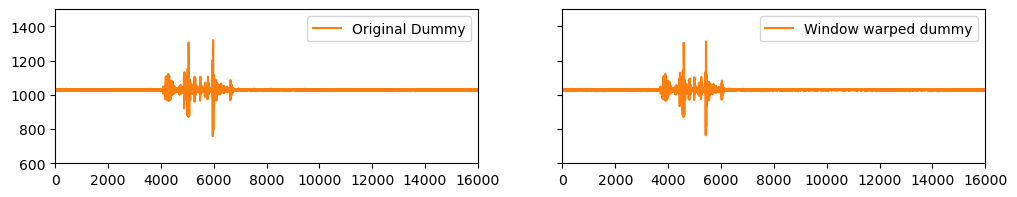

In [25]:
window_warped_dummy = Augmentation_methods.windowWarp(dummy_data[0], window_ratio=0.1, scales=[0.5, 2])
Augmentation_methods.plot_augmented(dummy_data[0], window_warped_dummy, orig_label = "Original Dummy", aug_label= "Window warped dummy" )

#### 5. Scaling <a name="subsubsubparagraph515"></a>
Scaling is a traditional augmentation method where the data is multiplied by a constant factor i.e applying constant noise to the entire samples.  In the scenario of detecting falls, this technique can simulate changes in the sensitivity of the sensors or variations in the environment.The <b>'scaling'</b> function accepts 'data' and 'sigma' as an input to the function. Data is the dummy data which is to be augmented and sigma refers to the standard deviation of the constant noise. The function returns the augmented data which is further passed to <b>'plot_augmented'</b> to visualize and compare the original and augmented data. 

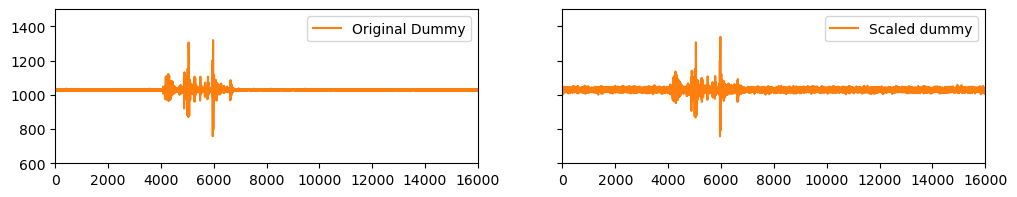

In [26]:
scaled_dummy = Augmentation_methods.scaling(dummy_data[0], 0.007)
Augmentation_methods.plot_augmented(dummy_data[0], scaled_dummy, orig_label = "Original Dummy", aug_label= "Scaled dummy" )

### Combined Traditional augmentation methods <a name="subsubparagraph52"></a>

Later, we combined the different augmentations to increase the variations in the original dummy data. The two augmentation methods have been combined in a way that the augmented data from the first augmentation method is passed as argument to the second augmentation method and the combined augmented data is obtained as the result.

#### 1. Jittering + Magnitude Warping <a name="subsubsubparagraph521"></a>

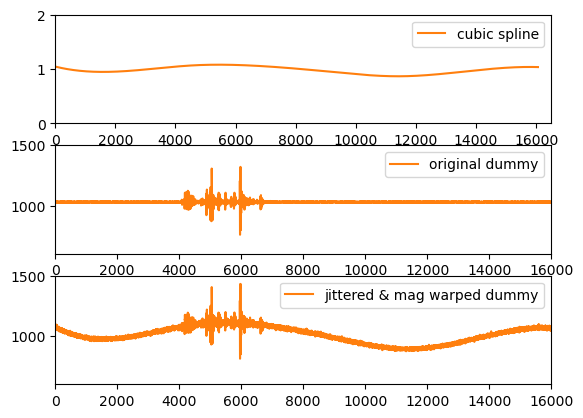

In [27]:
curve_JMW, jittered_magnitude_warped_dummy  =  Augmentation_methods.magnitudewarping((Augmentation_methods.add_white_noise(dummy_data[0], 0.50)),0.1, 6)
Augmentation_methods.plotcurve_mw(curve = curve_JMW, orig_dummy = dummy_data[0], aug_dummy = jittered_magnitude_warped_dummy, orig_label = 'original dummy', aug_label = 'jittered & mag warped dummy')

#### 2. Jittering + Time Warping <a name="subsubsubparagraph522"></a>

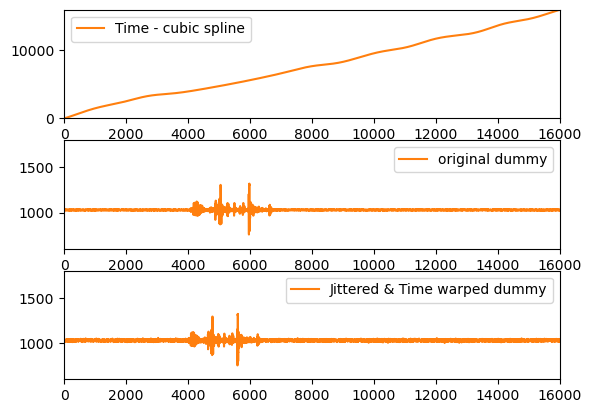

In [28]:
jittered_time_curve,Jittered_Time_warped_dummy, Jittered_Time_warped_dummy_stft = Augmentation_methods.DA_TimeWarp((Augmentation_methods.add_white_noise(dummy_data[0], 0.50)), 0.3, 20)
Augmentation_methods.plotcurve_tw(curve = jittered_time_curve, orig_dummy = dummy_data[0], aug_dummy = Jittered_Time_warped_dummy,orig_label = 'original dummy', aug_label = 'Jittered & Time warped dummy')

#### 3. Jittered + Window Warping <a name="subsubsubparagraph523"></a>

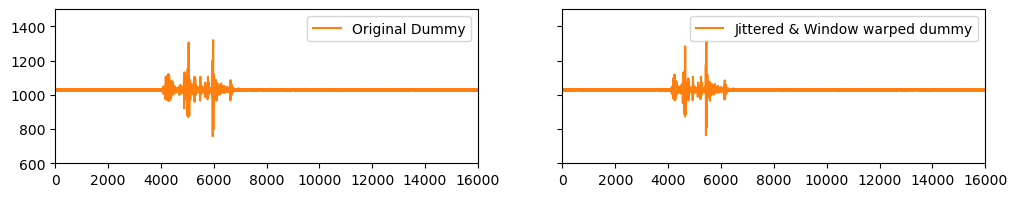

In [29]:
Jittered_window_warped_dummy = Augmentation_methods.windowWarp((Augmentation_methods.add_white_noise(dummy_data[0], 0.05)), window_ratio=0.1, scales=[0.5, 2.])
Augmentation_methods.plot_augmented(dummy_data[0], Jittered_window_warped_dummy, orig_label = "Original Dummy", aug_label= "Jittered & Window warped dummy" )

#### 4. Scaling and Magnitude warping <a name="subsubsubparagraph524"></a>

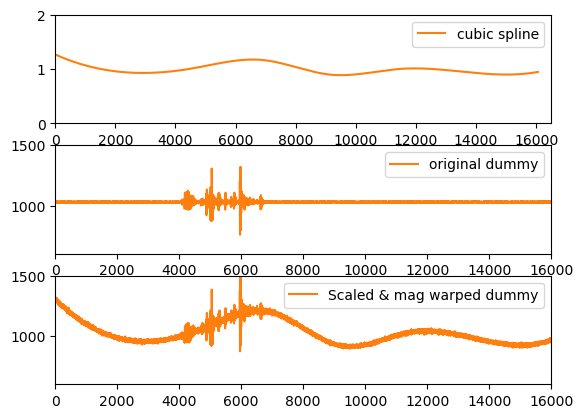

In [30]:
curve_SMW, scaled_magnitude_warped_dummy = Augmentation_methods.magnitudewarping((Augmentation_methods.scaling(dummy_data[0], 0.007)),0.1, 6)
Augmentation_methods.plotcurve_mw(curve = curve_SMW, orig_dummy = dummy_data[0], aug_dummy = scaled_magnitude_warped_dummy, orig_label = 'original dummy', aug_label = 'Scaled & mag warped dummy')

#### 5. Scaling and Time warping <a name="subsubsubparagraph525"></a>

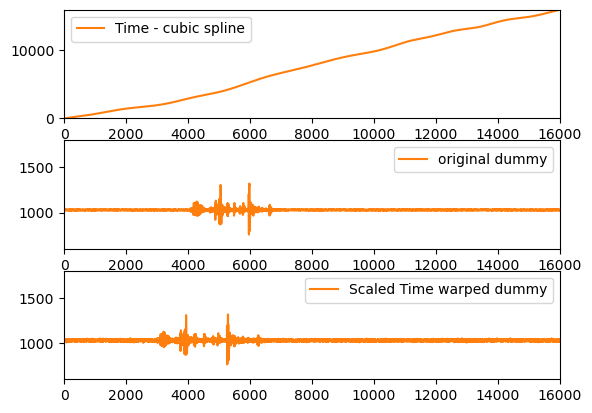

In [31]:
scaled_time_curve,scaled_Time_warped_dummy, scaled_Time_warped_dummy_stft = Augmentation_methods.DA_TimeWarp((Augmentation_methods.scaling(dummy_data[0], 0.007)), 0.3, 20)
Augmentation_methods.plotcurve_tw(curve = scaled_time_curve, orig_dummy = dummy_data[0], aug_dummy = scaled_Time_warped_dummy,orig_label = 'original dummy', aug_label = 'Scaled Time warped dummy')

#### 6. Magnitude and Window Warping <a name="subsubsubparagraph526"></a>

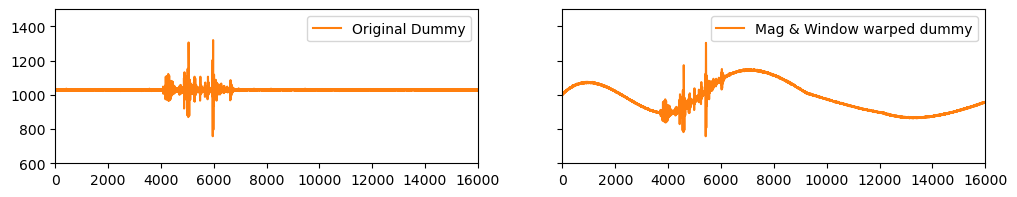

In [32]:
mag_warped  =  Augmentation_methods.magnitudewarping(dummy_data[0],0.1, 6)
mag_window_warped_dummy = Augmentation_methods.windowWarp(mag_warped[1] , window_ratio=0.1, scales=[0.5, 2.])

Augmentation_methods.plot_augmented(dummy_data[0], mag_window_warped_dummy, orig_label = "Original Dummy", aug_label= "Mag & Window warped dummy" )

Results from all traditional augmentation functions are combined in a list and this list is further passed to <b>'combined_stft'</b> function that plots <b>short-time fourier transform (STFT)</b> of all augmented data in a single plot.

In [33]:
Augmented_list = [dummy_data[0], Noise_dummy, magnitude_warped_dummy, Time_warped_dummy_stft, window_warped_dummy, scaled_dummy, jittered_magnitude_warped_dummy, Jittered_Time_warped_dummy_stft, Jittered_window_warped_dummy, scaled_magnitude_warped_dummy, scaled_Time_warped_dummy_stft, mag_window_warped_dummy]
label_list = ["dummy", "Jittered dummy", "magnitude warped dummy",'Time warped dummy', "Window warped dummy","scaled dummy","jittered & mag warped dummy","Jittered & Time warped dummy","Jittered & Window warped dummy", "Scaled & mag warped dummy", "Scaled & mag warped dummy", "Mag & Window warped dummy", mag_window_warped_dummy]

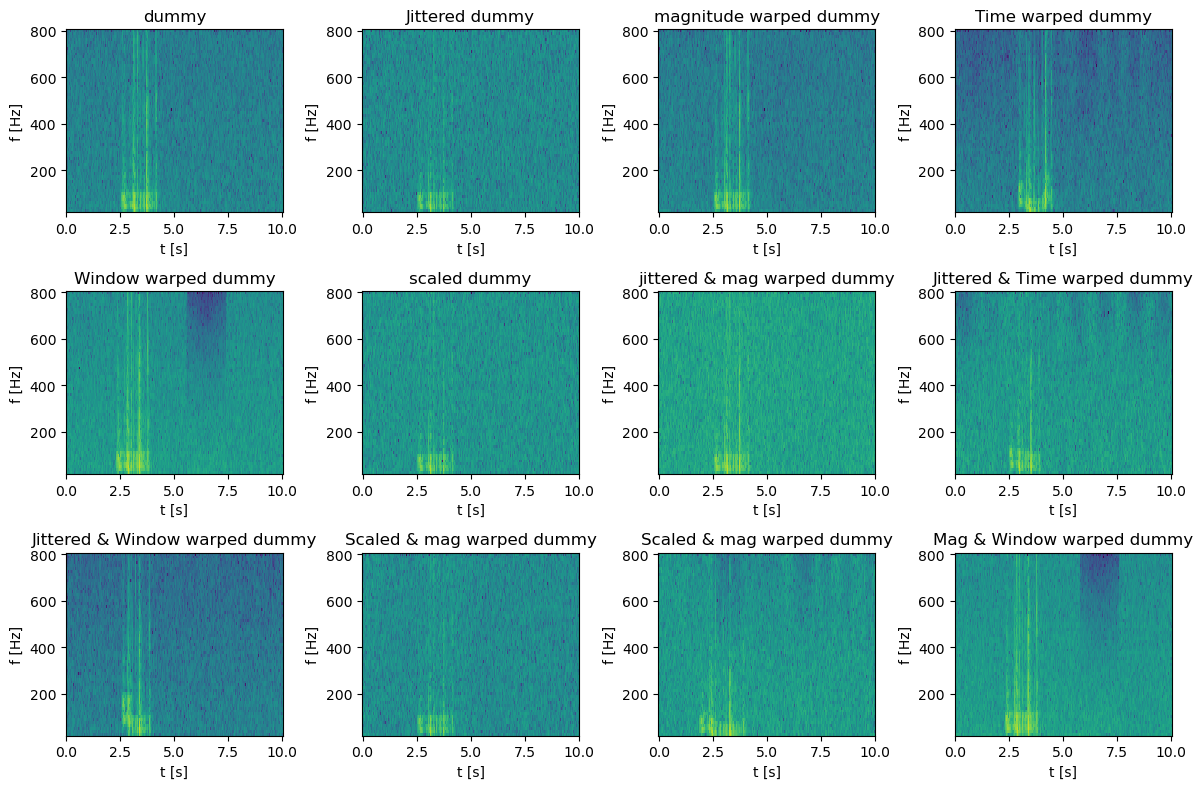

In [34]:
Augmentation_methods.combined_stft(Augmented_list,label_list)

### VAE augmentation <a name="subsubparagraph53"></a>
Apart from traditional augmentation, generative model based augmentation - Variational auto encoder (VAE) is used to augment dummy data. 
An Autoencoder (AE) is a type of neural network that is used for dimensionality reduction and feature learning. An autoencoder consists of two main components: 
- an <b>encoder</b> that maps the input data to a lower-dimensional representation
- a <b>decoder</b> that maps the lower-dimensional representation back to the original data space. <br>
The goal of the autoencoder is to learn a compact representation of the data that captures the essential patterns and structures in the data distribution.

A Variational Autoencoder (VAE) is a type of autoencoder that includes an additional constraint on the learned encoding. Specifically, the encoding in a VAE is modeled as a probabilistic distribution, and the goal of the VAE is to learn an encoding that not only captures the essential patterns and structures in the data, but also allows for random sampling from the encoding. This allows a VAE to generate new samples from the data distribution. Unlike autoencoder, the latent space here is not a vector but a distribution which is defined by the mean and standard deviation. In VAE, the loss function comprises of Kullback- liebler (KL) divergence loss and reconstruction loss which is to be minimized. KL loss quantifies the distance between the learned distribution and standard normal distribution whereas reconstruction loss how close the decoder output is to original input by using mean-squared error.

![VAE.png](figures/VAE.png)

In the above figure, the normalized Fourier transform spectrum values are the input data for the VAE. VAE is used to learn or encode z-axis accelerometer data from a high-dimensional data distribution to a lower-dimensional latent space. The fundamental features and patterns captured in the mean distribution is defined by the mean and standard deviation of the input data. By taking samples from the latent space and then remapping them to the initial data space, the trained VAE is used to generate new samples from the mean distribution. Since this latent space contains a lot of void spaces, the trained VAE will create noise instead of data that is similar to the original when it samples points in such regions. As a result, rather than sampling the entire latent space, which can lead to inaccurate augmentation, a convex hull (which will be described in more detail later) is mapped around these sample points to form an area. In order to predict and produce new samples, points are sampled from it and sent to the decoder. In this manner, the quality of augmentation is significantly increased reducing the probability of noisy data to be augmented.

##### Data Preparation of dummy data for train and test

In [35]:
# Cleaned dummy data
cleaned_dummy_df = cleaned_dummy.drop("label", axis=1)
# Divide the cleaned dummy data into 60% for training and 40% for testing.
dummy_train = cleaned_dummy_df.sample(frac = 0.60)
dummy_test = cleaned_dummy_df.drop(dummy_train.index)
dummy_train.reset_index(drop=True, inplace=True)
dummy_test.reset_index(drop=True, inplace=True)     

In [36]:
# Dataframe preparation for dummy  d
dummy_train_df, nf_train = data_preparation.dataframe_prep(dummy_train)
dummy_test_df, nf_test = data_preparation.dataframe_prep(dummy_test)

In [37]:
X_train_vae = np.stack(dummy_train_df["normalizedSpectrum"])
y_train_vae = dummy_train_df["istSturz"]

In [38]:
input_shape = (63, 251, 1)
latent_dim = 2
encoder, conv_shape = vae_augmentation.build_encoder(input_shape, latent_dim)
decoder = vae_augmentation.build_decoder(conv_shape, latent_dim)

![encoderdecoder.png](figures/encoderdecoder.png)

- From the above summary of encoder and decoder, we can clearly see the behavior of VAE. In the encoder, beginning with the input shape as(63,251,1) the dimensionality is reduced which is reconstructured back in the decoder with the decoder_output shape being same as the encoder input shape.

In [ ]:
# Training VAE model with train data 
vae = vae_augmentation.VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam())
vae.fit(X_train_vae, epochs = 30,batch_size=9)

#### Convex Hull <a name="subsubsubparagraph21"></a>

The convex hull of a set of points is defined as the smallest convex polygon, that encloses all of the points in the set. Convex means that the polygon has no corner that is bent inwards. In our case, encoder is used to predict the mean distribution of the train data, that results number of points in a latent space. There are lot of empty spots in this space which are not optimal for data generation using decoder. Hence Convex hull is implemented which form an polyogon using the outermost points of the distribution which can be seen in the second plot. Further, depending on how much data is to be augmented, 'n' points can be generated in this convex hull and passed to decoder for prediction i.e data augmentation. 

In [40]:
#Convex Hull to define the sample space
def plot_mean_distribution_with_hull(X_train_vae, train_part_df, vae, n):
    z_mean, z_log_var, z = vae.encoder.predict(X_train_vae)
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    ax[0].scatter(z_mean[:, 0], z_mean[:, 1], c=train_part_df["istSturz"])
    ax[0].set_xlabel("z[0]")
    ax[0].set_ylabel("z[1]")
    ax[0].set_title("mean distribution")

    hull = ConvexHull(z_mean)
    for simplex in hull.simplices:
        ax[1].plot(z_mean[simplex, 0], z_mean[simplex, 1], 'k-')
    ax[1].scatter(z_mean[:, 0], z_mean[:, 1], c=train_part_df["istSturz"])
    ax[1].set_xlabel("z[0]")
    ax[1].set_ylabel("z[1]")
    ax[1].set_title("Convex hull")

    bbox = [hull.min_bound, hull.max_bound]
    hull_path = Path(hull.points[hull.vertices])
    rand_points = np.empty((n, 2))
    for i in range(n):
        rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
        while hull_path.contains_point(rand_points[i]) == False:
            rand_points[i] = np.array([np.random.uniform(bbox[0][0], bbox[1][0]), np.random.uniform(bbox[0][1], bbox[1][1])])
    ax[2].scatter(z_mean[:, 0],z_mean[:, 1], marker='o',  c='blue', alpha = 1, label ='Initial points')
    for simplex in hull.simplices:
        ax[2].plot(hull.points[simplex, 0], hull.points[simplex, 1], '-k')
    ax[2].scatter(rand_points[:, 0],rand_points[:, 1], marker='o',  c='red', alpha = 0.31, label ='Random points inside hull')
    ax[2].legend()
    ax[2].set_title("Sampled points")
    plt.show()
    return rand_points

2/2 [==============================] - 0s 22ms/step


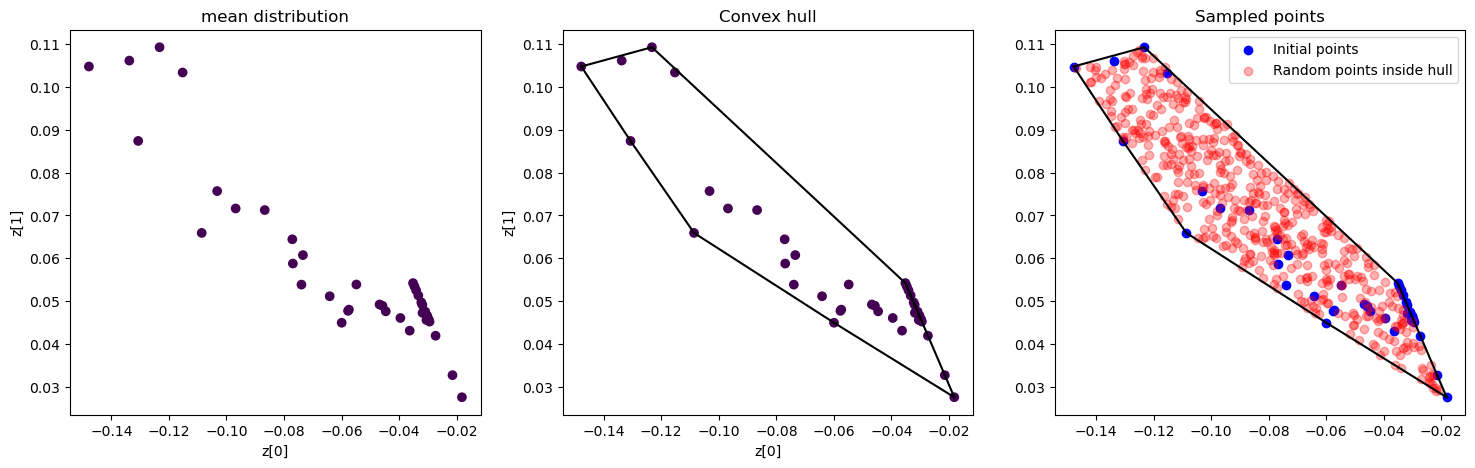

In [41]:
sample_points = plot_mean_distribution_with_hull(X_train_vae = X_train_vae, train_part_df = dummy_train_df, vae = vae, n = 500)

In [ ]:
vae_augmented =  vae_augmentation.aug_data_vae(vae,sample_points)

In [43]:
vae_df = data_preparation.vae_prep(vae_augmented, nf_train)
vae_df.head(2)

,event,istSturz,signalLenght,spectrum,normalizedSpectrum
0,Dummy,1,16000,"[[[67.09368], [19.62541], [9.14024], [3.866846...","[[[0.1951306], [0.05707718], [0.026582839], [0..."
1,Dummy,1,16000,"[[[67.09336], [19.62264], [9.137053], [3.86495...","[[[0.19512966], [0.057069127], [0.026573569], ..."


- It is important to note that the convex hull limits the VAE model to augment noisy data by restricting the sampling of points to a limited area around the mean distribution(but it can also lead to duplication of data(with negligible variation in data) if the points are restricted to a very small region and a convex hull is formed around that region for sampling)

## Training CNN using augmented and lab data <a name="subparagraph6"></a>

The previous model was overfitting because of shortage and nature of the data. The data that was fed to CNN was highly imbalanced as the class 0(Other falls) were more as compared to class 1 (dummy falls). All the above augmentation methods are applied on the dummy fall data to increase the dummy falls, so that the input data is more balanced and the model gets trained on several variations of the dummy fall data and performs well on the unseen data. 

In [44]:
# Traditional augmentation of all dummy events
augmented_dummy = []

for i, event in enumerate(dummy_train.to_numpy().ravel()): 
    
    # Jittering
    augmented_dummy.append(Augmentation_methods.add_white_noise(event, 0.15))
    augmented_dummy.append(Augmentation_methods.add_white_noise(event, 0.12))
    augmented_dummy.append(Augmentation_methods.add_white_noise(event, 0.08))
    augmented_dummy.append(Augmentation_methods.add_white_noise(event, 0.05))
    
    # Magnitude Warping
    magnitude_warped_dummy =  Augmentation_methods.magnitudewarping(event,0.1, 20) 
    augmented_dummy.append(magnitude_warped_dummy[1])
    magnitude_warped_dummy1 =  Augmentation_methods.magnitudewarping(event,0.1, 15) 
    augmented_dummy.append(magnitude_warped_dummy1[1])
    magnitude_warped_dummy2 =  Augmentation_methods.magnitudewarping(event,0.1, 10) 
    augmented_dummy.append(magnitude_warped_dummy2[1])
    
    # Window Warping
    augmented_dummy.append(Augmentation_methods.windowWarp(event, window_ratio=0.1, scales=[0.5, 2.]))
    
    # Jittering + Magnitude warping
    curve_JMW, jittered_magnitude_warped_dummy  =  Augmentation_methods.magnitudewarping((Augmentation_methods.add_white_noise(event, 0.50)),0.1, 10)
    augmented_dummy.append(jittered_magnitude_warped_dummy)
    
    # Jittering + window warping
    augmented_dummy.append(Augmentation_methods.windowWarp((Augmentation_methods.add_white_noise(event, 0.50)), window_ratio=0.1, scales=[0.5, 2.]))
    
    # Magnitude warping + window warping
    mag_warped  =  Augmentation_methods.magnitudewarping(event,0.1, 10)
    mag_window_warped_dummy = Augmentation_methods.windowWarp(mag_warped[1] , window_ratio=0.1, scales=[0.5, 2.])
    augmented_dummy.append(mag_window_warped_dummy)
              
augmented_dummy_array = np.array(augmented_dummy,dtype = object)
augmented_df =pd.DataFrame(augmented_dummy_array,columns=['z'])

# Data preparation of augmented data
aug_df, nf_aug = data_preparation.dataframe_prep(augmented_df)

In [45]:
# combining the augmented(traditional + VAE) and positive events df
pos_aug_df = []
pos_aug_df = pos_event_df.append(vae_df)
pos_aug_df = pos_aug_df.drop("run", axis=1)
pos_aug_df = pos_aug_df.append(aug_df)

#shuffle the final dataframe
pos_aug_df = pos_aug_df.sample(frac=1).reset_index(drop=True)

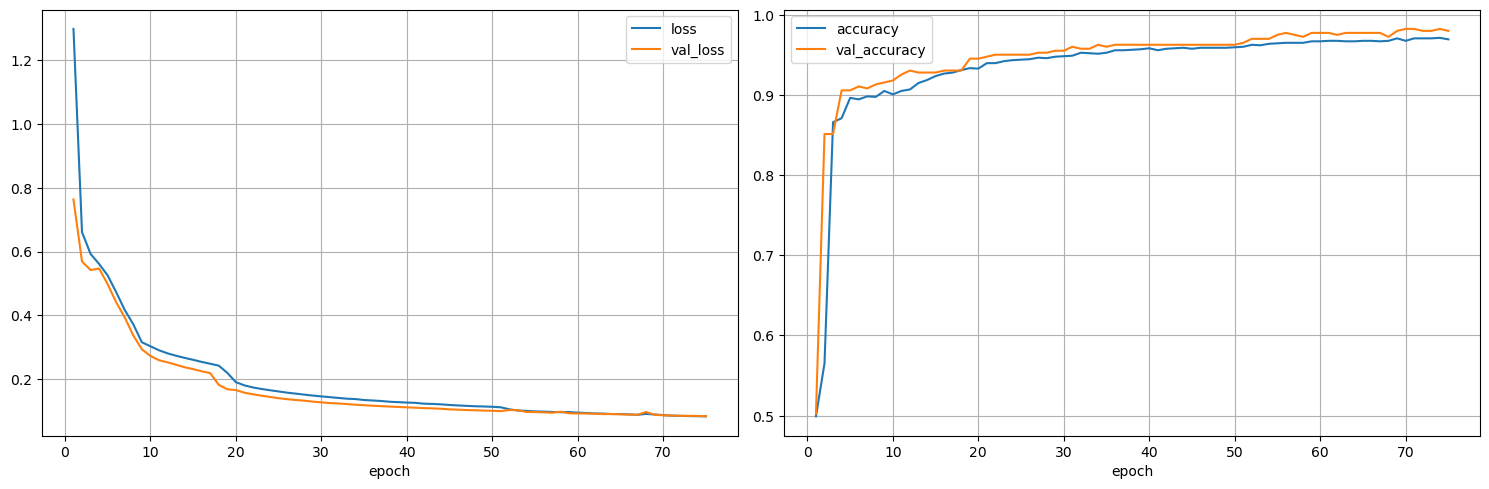

51/51 [==============================] - 1s 14ms/step - loss: 0.0846 - accuracy: 0.9697 - val_loss: 0.0852 - val_accuracy: 0.9802


In [46]:
# Defining features and target
X = np.stack(pos_aug_df["normalizedSpectrum"].to_list())
y = pos_aug_df["istSturz"].to_numpy()

# CNN model
mdl_new = data_preparation.build_model()

# split data in train and test set
train_new, test_new = train_test_split(range(len(y)), test_size=0.2,stratify= y)

# Training and plotting the loss and accuracy for training and the validation dataset for every epoch
callbacks_list = [metrics.PlotLearning()]
history = mdl_new.fit(X[train_new, ], y[train_new], epochs=75, validation_data=(X[test_new,], y[test_new]),callbacks=callbacks_list)

- The above results can be compared to the previous CNN results. It can be observed that the current CNN model is <b>performing better</b> on the unseen data. Unlike the previous model where the accuracy was certainly high(above 90%) from the very first epoch, in the current CNN model (including the augmented data) the overall training and validation accuracy after the first epoch is around 50% and it gradually increases with increase in the epochs with an <b>accuracy of 98%</b> after 50 epochs.The training and validation loss also reduces gradually with the increasing epochs.

In [51]:
# Evaluation of model
ypred = mdl_new.predict(X).ravel()
threshold = 0.10
pd.crosstab(pos_aug_df['event'], ypred >= threshold)

64/64 [==============================] - 0s 3ms/step


col_0,False,True
event,,
1.5L Flasche,41,31
2 Bücher,66,6
Dummy,3,1009
Getränkeflasche,71,1
Handy,72,0
Hantel,71,0
Koffer,57,15
Krücken,72,0
Möbel verrücken,69,3


- The trained model is used to predict fall events, and it is noted that the model correctly classifies all real falls. Although some fake falls are mistakenly classified as real falls, this is considered acceptable as long as all actual falls are accurately identified.<b> It is imperative that real falls are never missed, as this can result in serious harm to the individual who has fallen if not attended. Reporting a fake fall as a real one is less concerning compared to failing to report an actual fall.</b>

## Cross Validation with different configurations <a name="subparagraph7"></a>

To further test the performance of the current CNN model,the augmented data is combined along with the original data in different configurations differing in the way they are trained and evaluated on the same data to have a clear comparison. The startified cross-validation was performed on 4 different configurations shown in the figure below. 

![cross_validation.png](figures/cross_validation.png)

The diagram shows the combination in which different data is splitted and used for training and testing. <b>'Other Event Data'</b> are fake fall events apart from the dummy falls and hence they are class 0 events. The <b>'Dummy Event Data'</b> are the real fall events and hence belong to class 1. <b>'Augmented Data'</b> are obtained from various augmentation performed on the specified(60%) of the dummy data and hence also belong to class 1.Other events data and dummy data are splitted in the ratio of 60% and 40%. 60% of both the data is used for training and 40% of the both the data in combination is kept aside for final testing of all the models obtained after cross-validation. For training data, the different configurations take different combinations of data specified below:

- <b>Config 1</b>: Other Event Data + Dummy Event Data
- <b>Config 2</b>: Other Event Data + Dummy Event Data + Augmented Data
- <b>Config 3</b>: Other Event Data + Augmented Data
- <b>Config 4 (Performed in two steps,Train and Re-train)</b>:

     <b>Train</b> : 30% of Other Event Data + Augmented Data <br>
     <b> Re-train</b>: 30% of Other Event Data + Dummy Event Data
               
In all the configurations described, the model is never exposed to the test data, which consists of 40% of the data. The augmented data used by the model is obtained by augmenting 60% of the dummy data and does not include the remaining 40% of the data or any duplicated, amplified, or augmented version of it.



The models from each cross-validation are stored and further used for prediction on the test data. Final metrics for train and the test dataset are obtained and displayed for comparisons. This steps helps us to identify which combination performs the best and will be suitable for future use when real falls from nursing home will be available.

### Data preparation for cross validation <a name="subsubparagraph71"></a>

#### Test Data for final prediction

In [54]:
# Data preparation for test (remaining 40% data)
pos_event_test_nodummy_df = pos_event_test_df.drop("run", axis=1)
pos_event_test_nodummy_df = pos_event_test_nodummy_df.drop(pos_event_test_nodummy_df[(pos_event_test_nodummy_df['event'] == "Dummy")].index)

# Test dataframe
test_df = []
test_df = pos_event_test_nodummy_df.append(dummy_test_df)

# Test data
X_tst = np.stack(test_df["normalizedSpectrum"].to_list())
y_tst = test_df["istSturz"].to_numpy()

#### Train data preparation

##### Config 1

In [55]:
# Data Prep for training : Append 60% positive event df(Excluding dummy) and 60% dummy df
pos_event_nodummy_df= pos_event_train_df.drop("run", axis=1)
pos_event_nodummy_df = pos_event_nodummy_df.drop(pos_event_nodummy_df[(pos_event_nodummy_df['event'] == "Dummy")].index)

cv_1_df = []
cv_1_df = pos_event_nodummy_df.append(dummy_train_df)
cv_1_df.reset_index(drop=True, inplace=True)

##### Config 2

In [56]:
# Data preparation for training: Append 60% positive event df(Excluding dummy), 60% dummy df and augmented df
cv_2_df = []
cv_2_df = cv_1_df.append(aug_df)
cv_2_df = cv_2_df.append(vae_df)
cv_2_df.reset_index(drop=True, inplace=True)

##### Config 3

In [57]:
# Data Prep for training : Append 60% positive event df(Excluding dummy) and augmented df
cv_3_df = []
cv_3_df = pos_event_nodummy_df.append(aug_df)
cv_3_df = cv_3_df.append(vae_df)
cv_3_df.reset_index(drop=True, inplace=True)

##### Config 4

In [58]:
# Data Prep for training : Re-training with dummy data only
pos_event_nodummy_train_df = pos_event_nodummy_df.sample(frac = 0.50)
pos_event_nodummy_retrain_df = pos_event_nodummy_df.drop(pos_event_nodummy_train_df.index)

cv_4_df = []
cv_4_df = pos_event_nodummy_train_df.append(vae_df)
cv_4_df = cv_4_df.append(aug_df)

cv_4_retrain_df= []
cv_4_retrain_df = dummy_train_df.append(pos_event_nodummy_retrain_df)

cv_4_df.reset_index(drop=True, inplace=True)
cv_4_retrain_df.reset_index(drop=True, inplace=True)

##### Features and target for different configurations

In [59]:
df_list = [cv_1_df,cv_2_df,cv_3_df,cv_4_df,cv_4_retrain_df]
new_xy_sets = data_preparation.features_and_target(df_list)

### Cross validation Metrics <a name="subsubparagraph72"></a>

When evaluating the performance of a machine learning model in a scenario where it is crucial to not miss any mis-classifications, accuracy may not provide a comprehensive assessment. In such cases, it is necessary to consider other metrics that specifically address the imbalance in the data. To account for this imbalance, we have calculated the True Positive Rate (TPR), False Positive Rate (FPR), True Negative Rate (TNR), and False Negative Rate (FNR). These metrics provide a more nuanced understanding of the model's performance.Precision and recall are considered the most important metrics in such scenarios, as they focus on correctly identifying events that have actually taken place. As a result, we have chosen to use the AUC-ROC (Area Under the Receiver Operating Characteristic curve) and Precision-Recall curve as our evaluation metrics for the cross-validation process. These metrics provide a visual representation of the trade-off between precision and recall and allow us to compare the performance of different models.

Furthermore, we have included a confusion matrix as a metric for each fold in various configurations for the training data as well as the predictions on the test data. This matrix provides a comprehensive representation of the model's performance in terms of true positives, false positives, true negatives, and false negatives. This information is crucial in understanding the model's strengths and weaknesses and helps us make informed decisions about the next steps in the development process.

In [60]:
config = ['config 1' , 'config 2', 'config 3' , 'config 4', 'config 4 retrain'] 

mdl_cv_list = []
acc_per_fold_list = []
loss_per_fold_list = []
confusion_matrices_list = []
roc_values_list = []
precision_recall_values_list = []
auc_list = []
F1_score_list = []

fpr = []
tpr = []
threshold = [] 
precision = [] 
recall = []
threshold_1 = []

cv_metrics_df = pd.DataFrame()
cv_param_df = pd.DataFrame()

In [ ]:
i = 0
for X, y in new_xy_sets:
    
    if i <4:
        mdl_cv1, acc_per_fold, loss_per_fold, confusion_matrices, roc_values, precision_recall_values, auc_1, F1_score = metrics.train_skfold_model(X, y, num_folds=5, no_epochs=75, optimizer='adam', loss_function='binary_crossentropy', verbosity=0)
    else:
        mdl_cv1, acc_per_fold, loss_per_fold, confusion_matrices, roc_values, precision_recall_values, auc_1 ,F1_score = metrics.retrain_skfold_model(mdl_cv1, X, y, num_folds=5, no_epochs=75, optimizer='adam', loss_function='binary_crossentropy', verbosity=0)
        
    fpr, tpr, threshold, precision, recall, threshold_1 = roc_values[0], roc_values[1], roc_values[2], precision_recall_values[0], precision_recall_values[1], precision_recall_values[2]
    # df_1 , df2 = metrics.store_cv_results(config[i],acc_per_fold, loss_per_fold, confusion_matrices, roc_values, precision_recall_values, auc_1, F1_score)
    df_1, df2 = metrics.store_cv_results(config[i],acc_per_fold, loss_per_fold, confusion_matrices, roc_values, precision_recall_values, auc_1, F1_score)
    i=i+1
    cv_metrics_df = pd.concat([cv_metrics_df, df_1], ignore_index=True)
    cv_param_df = pd.concat([cv_param_df, df2], ignore_index=True)
    
    mdl_cv_list.append(mdl_cv1)
    acc_per_fold_list.append(acc_per_fold)
    loss_per_fold_list.append(loss_per_fold)
    confusion_matrices_list.append(confusion_matrices)
    roc_values_list.append(roc_values)
    precision_recall_values_list.append(precision_recall_values)
    auc_list.append(auc_1)
    F1_score_list.append(F1_score)

cv_metrics_df = cv_metrics_df[cv_metrics_df.Configuration != 'config 4']
cv_metrics_df = cv_metrics_df.reset_index(drop=True)
mdl_cv_list.pop(3) #Dropping the 4th Configuration train model and keeping the retrained model configuration. 
roc_values_list.pop(3)
precision_recall_values_list.pop(3)

In [62]:
# returns all the metrics for different configurations
cv_metrics_df

,Configuration,fold,accuracy,loss,auc,F1_score,confusion_matrix
0,config 1,1,97.674417,0.071823,0.995868,0.800000,"[[117, 4], [0, 8]]"
1,config 1,2,96.899223,0.092598,0.980372,0.600000,"[[115, 6], [2, 6]]"
2,config 1,3,98.437500,0.032615,1.000000,0.888889,"[[118, 2], [0, 8]]"
3,config 1,4,98.437500,0.045830,1.000000,0.888889,"[[118, 2], [0, 8]]"
4,config 1,5,96.875000,0.063435,0.991667,0.727273,"[[114, 6], [0, 8]]"
5,config 2,1,99.684542,0.015579,0.999789,0.992366,"[[119, 2], [1, 195]]"
6,config 2,2,100.000000,0.006992,1.000000,0.994924,"[[119, 2], [0, 196]]"
7,config 2,3,96.518987,0.127266,0.990136,0.946602,"[[99, 21], [1, 195]]"
8,config 2,4,96.518987,0.329417,0.974405,0.951456,"[[100, 20], [0, 196]]"
9,config 2,5,100.000000,0.003215,1.000000,1.000000,"[[120, 0], [0, 196]]"


#### Confusion Matrix <a name="subsubsubparagraph721"></a>

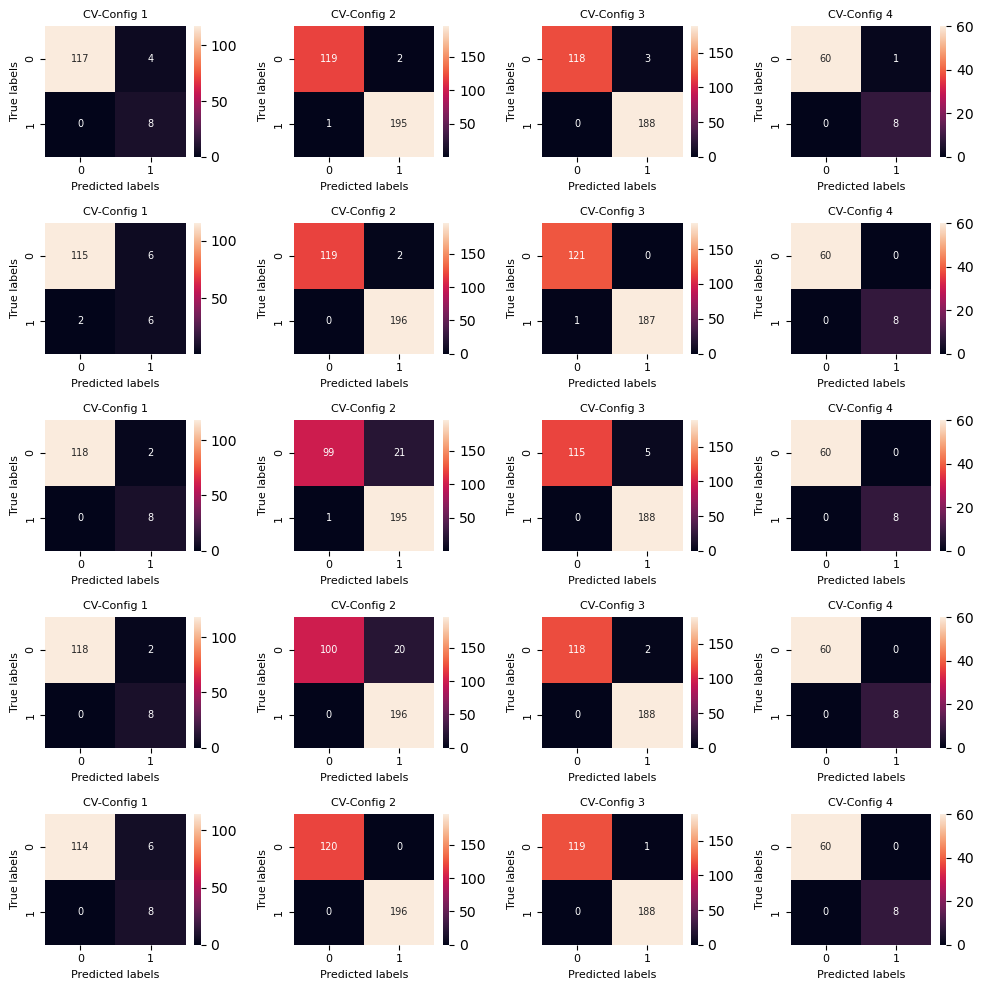

In [63]:
# Extract the values of the 'Confusion Matrix' column
cm_list = cv_metrics_df['confusion_matrix'].tolist()

fig, axs = plt.subplots(5, 4, figsize=(10,10))
fig.subplots_adjust(wspace=0.7, hspace=0.5)

# Plot each confusion matrix in a separate subplot
for i, cm in enumerate(cm_list):
    row = i % 5
    col = i // 5
    sns.heatmap(cm, annot=True,annot_kws={"size": 7}, fmt='g', ax=axs[row, col])
    axs[row, col].set_xlabel('Predicted labels', fontsize=8)
    axs[row, col].set_ylabel('True labels', fontsize=8)
    axs[row, col].set_title(f'CV-Config {(i // 5) + 1}', fontsize=8)
    axs[row, col].xaxis.set_ticklabels(['0', '1'], fontsize=8)
    axs[row, col].yaxis.set_ticklabels(['0', '1'], fontsize=8)
    
# Tighten the layout and show the plot
plt.tight_layout()
plt.show()

- In the all the 4 configurations, the configuration 2 and 3 are seen to be performing well as it has correctly classified all the falls. In 2nd and 3rd configuratio, the model is training with large amount of dummy and augmented data and hence it is performing much better as compared to the other configuration.

#### ROC and Precision Recall Curves <a name="subsubsubparagraph722"></a>

The <b>AUC - ROC curve</b> is a performance metric for classification problems at various threshold levels. AUC represents the degree or measure of separability, while ROC is a probability curve. It indicates how well the model can distinguish between classes. The greater the AUC, the better the model predicts 0 classes as 0 and 1 classes as 1. Similarly, the higher the AUC, the better the model distinguishes between real fall and no fall. ROC curve is normally used when there is for balanced dataset and precision recall curve is used for imbalanced data. To achieve a recall of 1, we have modified our code to return a threshold when recall if 1. This threshold is used for final prediction on the test data.The ROC curve is plotted with TPR versus FPR, with TPR on the y-axis and FPR on the x-axis.

[<AxesSubplot: > <AxesSubplot: > <AxesSubplot: > <AxesSubplot: >]
For fold 1, optimal Threshold=0.146579, G-Mean=0.988
For fold 2, optimal Threshold=0.046071, G-Mean=0.962
For fold 3, optimal Threshold=0.428291, G-Mean=1.000
For fold 4, optimal Threshold=0.315924, G-Mean=1.000
For fold 5, optimal Threshold=0.135607, G-Mean=0.979
For fold 1, optimal Threshold=0.874788, G-Mean=0.997
For fold 2, optimal Threshold=0.625215, G-Mean=1.000
For fold 3, optimal Threshold=0.507213, G-Mean=0.960
For fold 4, optimal Threshold=0.757052, G-Mean=0.965
For fold 5, optimal Threshold=0.696101, G-Mean=1.000
For fold 1, optimal Threshold=0.961157, G-Mean=0.997
For fold 2, optimal Threshold=0.374519, G-Mean=0.997
For fold 3, optimal Threshold=0.973699, G-Mean=1.000
For fold 4, optimal Threshold=0.900624, G-Mean=1.000
For fold 5, optimal Threshold=0.478731, G-Mean=0.997
For fold 1, optimal Threshold=0.932885, G-Mean=1.000
For fold 2, optimal Threshold=0.971828, G-Mean=1.000
For fold 3, optimal Threshold=0.9

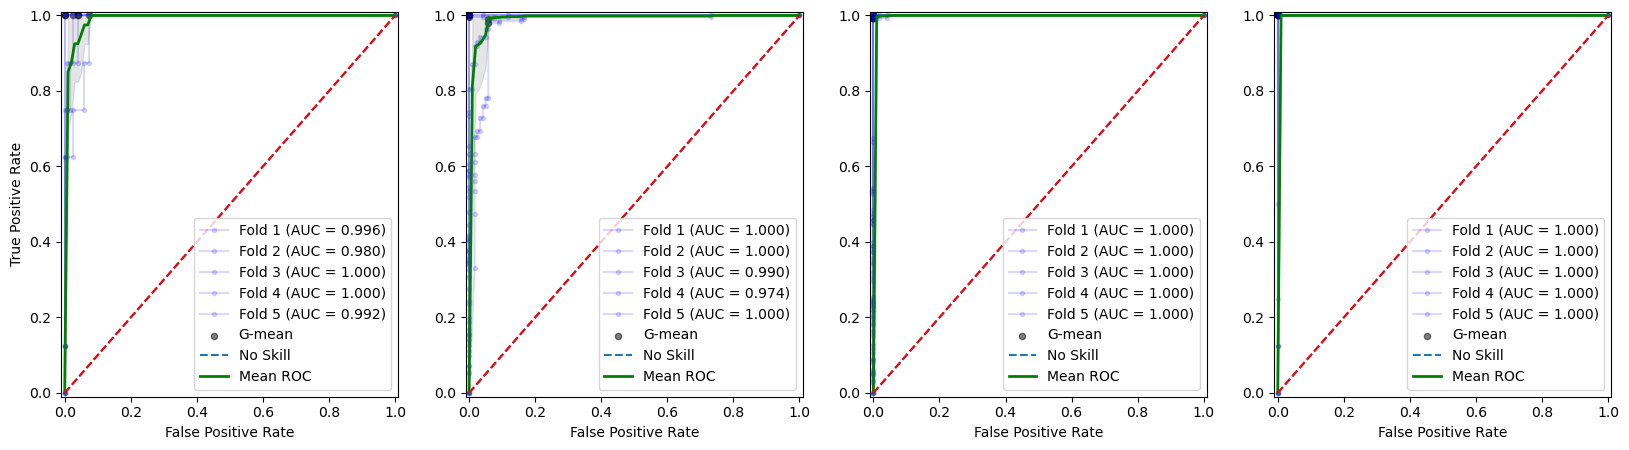

In [64]:
metrics.plot_roc_plot(roc_values_list, 5,cv_metrics_df.auc)

- Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.Larger values on the y-axis of the plot indicate higher true positives and lower false negatives. The higher the area under the ROC curve, the better the classifier. 
In the above plot, the Gmean is calculated for each fold and threshold is obtained using the maximum value of Gmean.
From the above plots, area under the curve for each plot is almost one that means the model is classifying all the falls correctly. 

<b>Precision-recall curves</b> is created by plotting the precision (the fraction of true positive predictions among all positive predictions made by the classifier) against the recall (the fraction of true positive instances that the classifier was able to detect). A high precision indicates that the classifier makes very few false positive predictions, while a high recall indicates that the classifier is able to detect most of the positive instances. The trade-off between precision and recall can be adjusted by varying the decision threshold of the classifier.

For Config1 fold 1 Best Threshold=0.237, F-Score=0.875
For Config1 fold 2 Best Threshold=0.403, F-Score=0.769
For Config1 fold 3 Best Threshold=0.428, F-Score=1.000
For Config1 fold 4 Best Threshold=0.316, F-Score=1.000
For Config1 fold 5 Best Threshold=0.485, F-Score=0.824
For Config2 fold 1 Best Threshold=0.875, F-Score=0.997
For Config2 fold 2 Best Threshold=0.625, F-Score=1.000
For Config2 fold 3 Best Threshold=0.507, F-Score=0.972
For Config2 fold 4 Best Threshold=0.757, F-Score=0.977
For Config2 fold 5 Best Threshold=0.696, F-Score=1.000
For Config3 fold 1 Best Threshold=0.961, F-Score=0.997
For Config3 fold 2 Best Threshold=0.375, F-Score=0.997
For Config3 fold 3 Best Threshold=0.974, F-Score=1.000
For Config3 fold 4 Best Threshold=0.901, F-Score=1.000
For Config3 fold 5 Best Threshold=0.165, F-Score=0.997
For Config4 fold 1 Best Threshold=0.933, F-Score=1.000
For Config4 fold 2 Best Threshold=0.972, F-Score=1.000
For Config4 fold 3 Best Threshold=0.993, F-Score=1.000
For Config

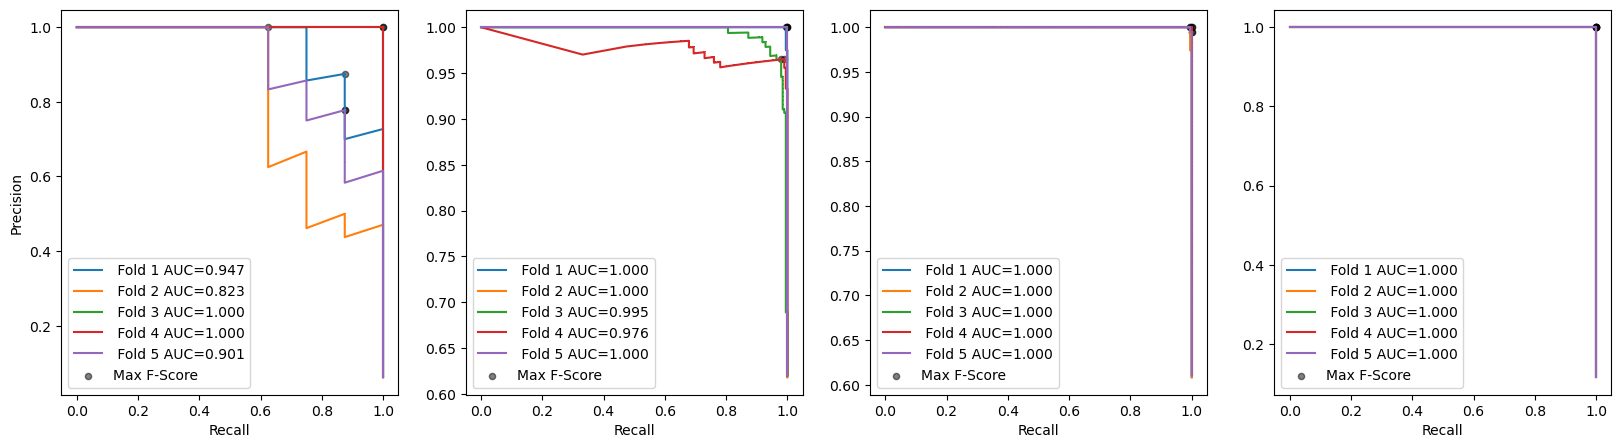

In [65]:
metrics.plot_precision_recall(precision_recall_values_list, 5)

- Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds. The above plot shows the max F1- Score for all the folds which is harmonic mean of the precision and recall.

In [66]:
cv_param_df.head(3)

,Configuration,fold,roc_threshold,precision,recall,precision_recall_threshold,fpr,tpr
0,config 1,1,"[1.998411, 0.99841106, 0.3136351, 0.29965466, ...","[0.06201550387596899, 0.0625, 0.06299212598425...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[2.983317e-13, 5.2751115e-08, 1.4005508e-07, 6...","[0.0, 0.0, 0.0, 0.008264462809917356, 0.008264...","[0.0, 0.125, 0.75, 0.75, 0.875, 0.875, 1.0, 1.0]"
1,config 1,2,"[1.9734457, 0.9734457, 0.40307498, 0.14341521,...","[0.06201550387596899, 0.0625, 0.06299212598425...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[8.040187e-10, 2.0917217e-07, 2.2415113e-06, 1...","[0.0, 0.0, 0.0, 0.024793388429752067, 0.024793...","[0.0, 0.125, 0.625, 0.625, 0.75, 0.75, 0.875, ..."
2,config 1,3,"[1.9984133, 0.9984134, 0.42829114, 2.6778447e-05]","[0.0625, 0.06299212598425197, 0.06349206349206...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[2.6778447e-05, 0.00017360206, 0.00021490843, ...","[0.0, 0.0, 0.0, 1.0]","[0.0, 0.125, 1.0, 1.0]"


#### Test metrics <a name="subsubsubparagraph723"></a>

The models obtained from the cross validation are used for predictions on the test data with the optimal threshols where recall is 1(,i.e lowest false negatives)and the following confusion matrices are plotted for visualization.

In [67]:
y_pred_tst_list, y_pred_binary_tst_list, cm_test_cv1_list, ct_list = metrics.predict_class(mdl_cv_list, X_tst, y_tst, test_df, 0.1)

14/14 [==============================] - 0s 3ms/step


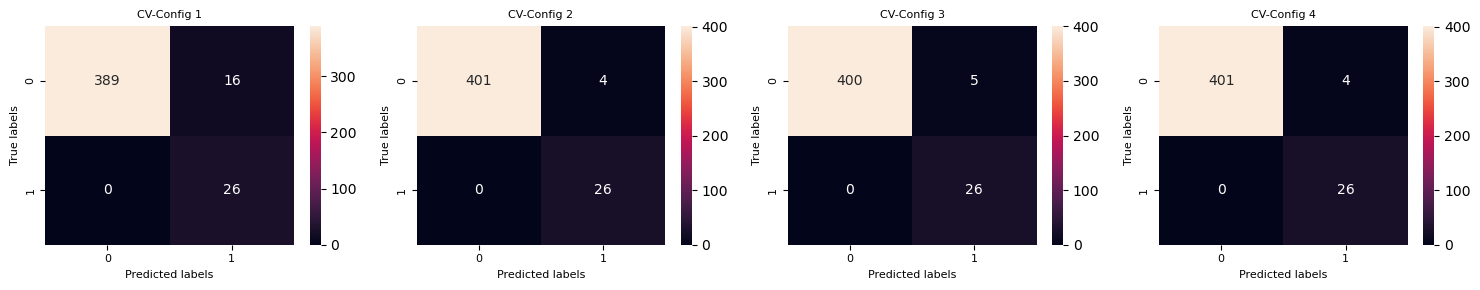

In [68]:
# Confusion matrix of predicted values based on initial threshold = '0.1'
cm_list_test = cm_test_cv1_list

# Create the figure and axis
fig, axs = plt.subplots(1, 4, figsize=(15,3))

# Plot each confusion matrix in a separate subplot
for i, cm in enumerate(cm_list_test):
    sns.heatmap(cm, annot=True, fmt='g', ax=axs[i])
    axs[i].set_xlabel('Predicted labels',fontsize=8)
    axs[i].set_ylabel('True labels',fontsize=8)
    axs[i].set_title(f'CV-Config {i + 1}',fontsize=8)
    axs[i].xaxis.set_ticklabels(['0', '1'],fontsize=8)
    axs[i].yaxis.set_ticklabels(['0', '1'],fontsize=8)

# Tighten the layout and show the plot
plt.tight_layout()
plt.show()

In [69]:
# Final prediction based on optimal threshold.
cv_test_result= pd.DataFrame()
for i, y_pred_tst in enumerate(y_pred_tst_list):
    auc_kpi_tst, apc_prc_tst, threshold_tst, conf_mat_model_tst, Accuracy_tst, Precision_tst, Recall_tst, Specificity_tst, F1_tst, roc_list_tst, prc_list_tst = metrics.evaluate_test(y_pred_tst, test_df['istSturz'])
    test_metrics_result = metrics.test_metrics(config[i],threshold_tst, conf_mat_model_tst, Accuracy_tst, Precision_tst, Recall_tst, Specificity_tst, F1_tst)
    cv_test_result = cv_test_result.append(test_metrics_result,ignore_index=True)


In [70]:
cv_test_result

,Configuration,Accuracy,Precision,Recall,Specificity,F1 Score,Threshold,Confusion Matrix
0,config 1,0.969838,0.666667,1.0,0.967901,0.800000,0.133536,"[[392, 13], [0, 26]]"
1,config 2,0.997680,0.962963,1.0,0.997531,0.981132,0.939981,"[[404, 1], [0, 26]]"
2,config 3,1.000000,1.000000,1.0,1.000000,1.000000,0.926938,"[[405, 0], [0, 26]]"
3,config 4,0.993039,0.896552,1.0,0.992593,0.945455,0.996395,"[[402, 3], [0, 26]]"


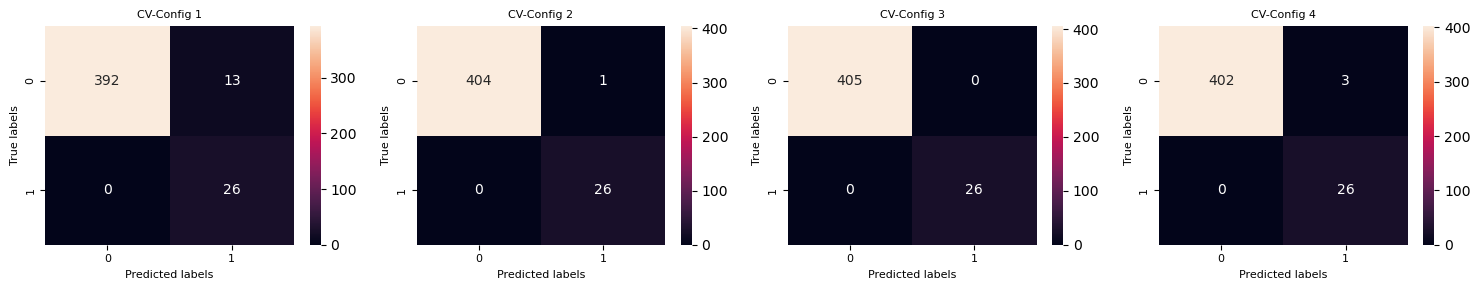

In [71]:
# Confusion matrix of predicted values based on optimal thresholds
cm_list_test = cv_test_result["Confusion Matrix"]

# Create the figure and axis
fig, axs = plt.subplots(1, 4, figsize=(15,3))

# Plot each confusion matrix in a separate subplot
for i, cm in enumerate(cm_list_test):
    sns.heatmap(cm, annot=True, fmt='g', ax=axs[i])
    axs[i].set_xlabel('Predicted labels',fontsize=8)
    axs[i].set_ylabel('True labels',fontsize=8)
    axs[i].set_title(f'CV-Config {i + 1}',fontsize=8)
    axs[i].xaxis.set_ticklabels(['0', '1'],fontsize=8)
    axs[i].yaxis.set_ticklabels(['0', '1'],fontsize=8)

# Tighten the layout and show the plot
plt.tight_layout()
plt.show()

Using the optimal threshold where the recall is 1, the confusion matrices are obtained. It can be observed that for all the configurations the mis-classification has reduced and specifically for configuration 3, both types of errors, false positives and false negatives have eliminated.

## Conclusion and future work <a name="paragraph2"></a>

In this report, the problem of overfitting and insufficient data was addressed through the proposal of artificially increasing the size of the training data using traditional and model-based augmentation techniques. The results showed improved performance through this approach. To further enhance performance, cross-validation was carried out using different configurations, and the improvement was demonstrated through evaluation metric plots. Among the configurations, Configuration 3 outperformed the others with the highest precision and recall values.

As future work, the configurations tested in this report can serve as a template for testing real fall data from a nursing home. Additionally, some of the augmentation methods can be further improved by incorporating more ratios (e.g., warping ratio for magnitude warping, noise ratio for jittering, etc.). It is important to note that while each augmentation has contributed to the performance, caution must be taken when increasing the effect of traditional augmentation techniques such as time warping, magnitude warping, and scaling. These techniques can significantly alter the original data and may have a negative impact on the model's performance.

Finally, further optimization of the model can be achieved through hyperparameter tuning. This will involve fine-tuning the model parameters to improve its performance and increase its accuracy in classifying fall events, for example, fine-tuning the learning rate, regularization term, and batch size. 

## References <a name="references"></a>

- Talavera, E. et al. (2022) Data augmentation techniques in time series domain: A survey and taxonomy, arXiv.org. Available at: https://arxiv.org/abs/2206.13508 (Accessed: February 06, 2023). 

- Um, T.T. et al. (2017) Data Augmentation of wearable sensor data for parkinson's disease monitoring using convolutional neural networks, arXiv.org. Available at: https://arxiv.org/abs/1706.00527 (Accessed: February 6, 2023). 

- Iwana, B.K. and Uchida, S. (2020) Time series data augmentation for neural networks by time warping with a discriminative teacher, arXiv.org. Available at: https://arxiv.org/abs/2004.08780 (Accessed: February 06, 2023). 

- Maestre, U.G., Zaragoza, J.C. and Gallego, A.J. (2018) data augmentation via variational auto-encoders - researchgate. Available at: https://www.researchgate.net/publication/331474083_Data_Augmentation_via_Variational_Auto-Encoders (Accessed: February 06, 2023). 

- Team, K. (no date) Keras documentation: Variational Autoencoder, Keras. Available at: https://keras.io/examples/generative/vae/ (Accessed: February 6, 2023). 

- Multiclass receiver operating characteristic (ROC) (no date) scikit. Available at: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html (Accessed: February 6, 2023). 

## Appendix <a name="appendix"></a>

We have developed several modules in which functions are defined. These functions are used throughout this notebook to optimize the code. Below image shows the path, name and details of each module.

![modules.png](figures/modules.png)

To get a detailed information regarding several stages of our work in individual notebooks can be referred to in the future.

![files.png](figures/files.png)